# Helio-centrics vs Planet-centric Models of the Solar System
Just having fun with how the "solar system" models will look like if it were centered around the Sun and different planets. The sizes of the sun and planets are in log scale. The distances from the sun are in log(distance + 1) scale.

We can see how the heliocentric (sun-centered) model is much simpler than the other models. When we use one of the planets (e.g. Earth) as the center, like in the Ptolemaic model, we observe that the other bodies will have to orbit smaller circles or loops as they orbit the planet. In the Ptolemaic model, these were called epicycles. When we look up in the night sky and track the planets, we do observe these paths where planets would do seem to reverse directions or loop back.

I decided not to include planets past Jupiter since their orbits are too large and their corresponding years are too long.

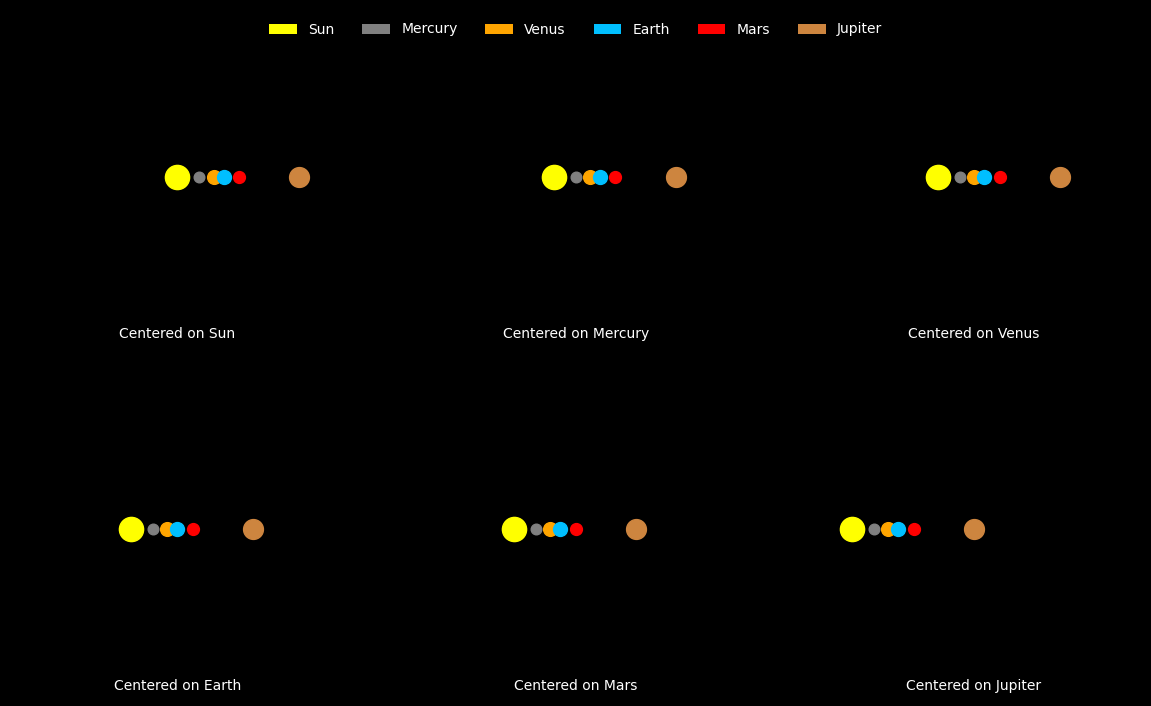

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

rc('animation', html='jshtml')
rcParams['animation.html'] = 'jshtml'

# Data for the planets and the Sun:
planets = {
    "Mercury": {"distance": 0.39, "period": 88,    "radius": 2439.7},
    "Venus":   {"distance": 0.72, "period": 225,   "radius": 6051.8},
    "Earth":   {"distance": 1.0,  "period": 365,   "radius": 6371},
    "Mars":    {"distance": 1.52, "period": 687,   "radius": 3389.5},
    "Jupiter": {"distance": 5.20, "period": 4331,  "radius": 69911},
    # "Saturn":  {"distance": 9.58, "period": 10747, "radius": 58232},
    # "Uranus":  {"distance": 19.20,"period": 30687, "radius": 25362},
    # "Neptune": {"distance": 30.07,"period": 59800, "radius": 24622}
}
sun_data = {"distance": 0, "period": None, "radius": 696340}

# Colors (approximate actual colors)
planet_colors = {
    "Mercury": "gray",
    "Venus":   "orange",
    "Earth":   "deepskyblue",
    "Mars":    "red",
    "Jupiter": "peru",
    # "Saturn":  "goldenrod",
    # "Uranus":  "lightblue",
    # "Neptune": "blue"
}
sun_color = "yellow"

# Create a unified dictionary for all bodies
bodies = {}
bodies["Sun"] = {"distance": sun_data["distance"],
                 "period": sun_data["period"],
                 "radius": sun_data["radius"],
                 "color": sun_color}
for name, data in planets.items():
    bodies[name] = {"distance": data["distance"],
                    "period": data["period"],
                    "radius": data["radius"],
                    "color": planet_colors[name]}

# Define the list of anchors (each panel will be centered on one of these bodies)
anchors = ["Sun", "Mercury", "Venus", "Earth", "Mars", "Jupiter"] # "Saturn", "Uranus", "Neptune"]

# Function to compute heliocentric positions on a logarithmic scale.
# If an anchor is provided, the returned coordinate is shifted so that
# the anchor’s heliocentric position appears at (0,0).
def get_coord(dist, rev_days, t, anchor_coord=(0,0)):
    """
    Compute (x, y) using a log-scale transformation.
    
    dist: distance in AU
    rev_days: orbital period in Earth days (if None, the object is stationary)
    t: time in Earth days
    anchor_coord: (x,y) offset to subtract from the computed position
    """
    r = np.log(dist + 1)  # 0 AU -> 0; 1 AU -> log(2)
    angle = 0 if rev_days is None else 2 * np.pi * t / rev_days
    return (r * np.cos(angle) - anchor_coord[0], r * np.sin(angle) - anchor_coord[1])

# Marker size function (using Earth's radius as baseline)
earth_radius = 6371  # km
baseline_marker = 100
def get_marker_size(radius):
    relative = radius / earth_radius
    return baseline_marker * (1 + np.log10(relative))

# Create a 3 x 3 grid of subplots.
fig, axs = plt.subplots(2, 3, figsize=(12, 7))
# Adjust the spacing to minimize unused space:
fig.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.05, hspace=0.05)
axs = axs.flatten()
# For each axis: remove borders/ticks, set background to black, and force the panel (axes patch) to be black.
for ax in axs:
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_aspect('equal')
    ax.set_facecolor('black')
    ax.patch.set_facecolor('black')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Set the overall figure background to black.
fig.patch.set_facecolor('black')

# Prepare dictionaries to hold scatter objects and trail histories.
scatter_dict = {}
trail_dict = {}
trails = {}
max_trail_length = 30  # maximum trail length

# For each panel (centered on a given anchor), create a scatter for every body.
for i, anchor in enumerate(anchors):
    ax = axs[i]
    ax.text(0.5, 0.01, f"Centered on {anchor}", transform=ax.transAxes, 
            ha='center', va='bottom', color="white")
    scatter_dict[anchor] = {}
    trail_dict[anchor] = {}
    trails[anchor] = {}
    # Compute the anchor's heliocentric position (with Sun as (0,0))
    anchor_pos = get_coord(bodies[anchor]["distance"], bodies[anchor]["period"], t=0, anchor_coord=(0, 0))
    for body, data in bodies.items():
        pos = get_coord(data["distance"], data["period"], t=0, anchor_coord=anchor_pos)
        size = get_marker_size(data["radius"])
        color = data["color"]
        sc = ax.scatter(pos[0], pos[1], s=size, color=color, label=body)
        scatter_dict[anchor][body] = sc
        trails[anchor][body] = []  # initialize empty trail list
        # Create an empty scatter for the trail.
        trail_sc = ax.scatter([], [], s=size/2, color=color, alpha=0.2)
        trail_dict[anchor][body] = trail_sc

def update(frame):
    t = frame  # current time in Earth days
    artists = []
    # Update each panel (each anchor) with all bodies' positions relative to that anchor.
    for anchor in anchors:
        # Compute the anchor's heliocentric position.
        anchor_pos = get_coord(bodies[anchor]["distance"], bodies[anchor]["period"], t, anchor_coord=(0, 0))
        for body, data in bodies.items():
            pos = get_coord(data["distance"], data["period"], t, anchor_coord=anchor_pos)
            scatter_dict[anchor][body].set_offsets([pos])
            # Update the trail history.
            trails[anchor][body].append(pos)
            if len(trails[anchor][body]) > max_trail_length:
                trails[anchor][body].pop(0)
            trail_coords = np.array(trails[anchor][body])
            num_points = len(trail_coords)
            alphas = np.linspace(0.1, 1, num_points)
            base_rgba = mcolors.to_rgba(data["color"])
            colors_list = [(base_rgba[0], base_rgba[1], base_rgba[2], alpha) for alpha in alphas]
            trail_dict[anchor][body].set_offsets(trail_coords)
            trail_dict[anchor][body].set_facecolors(colors_list)
            artists.append(scatter_dict[anchor][body])
            artists.append(trail_dict[anchor][body])
    return artists

# Create legend entries for all bodies.
legend_elements = [mpatches.Patch(facecolor=bodies[name]["color"], label=name) for name in bodies]
# Add a global legend at the very top, with several columns to span the width.
legend = fig.legend(handles=legend_elements, loc="upper center", ncol=len(planets.keys())+1, 
                    bbox_to_anchor=(0.5, 0.99), frameon=False)
# Set the legend text color to white.
for text in legend.get_texts():
    text.set_color("white")

# Animate the simulation (e.g., 2 Earth years stepping by 7 days).
anim = FuncAnimation(fig, update, frames=np.arange(0, 365*10, 7), blit=True)

In [42]:
from matplotlib.animation import PillowWriter
writer = PillowWriter(fps=30)
anim.save("./assets/solar_system.gif", writer=writer)

![solar_system](assets/solar_system.gif "solar_system")